# Generate and Parse Functions

In [ ]:
from cnn_sliding_window_feats import extract_features
import networkx as nx
import nmslib
import numpy as np
import csv
from os import path


def prepare_image_paths_labels():
    labels_file = "household_images/labels.csv"
    data = genfromtxt(labels_file, delimiter=',')
    return data


def prepare_image_paths_labels():
    directory_path = "household_images/images"
    labels_file = "household_images/labels.csv"

    with open(labels_file, "rt", encoding="utf8") as f_input:
        csv_input = csv.reader(f_input)
        header = next(csv_input)
        data = [row for row in csv_input]
    
    image_paths = [path.join(directory_path, row[0]) for row in data]
    image_labels = [int(row[1]) for row in data]
    
    return image_paths, image_labels


image_paths, image_labels = prepare_image_paths_labels()
features = extract_features(image_paths[:3])


descriptors = []

for feature in features:
    descriptors.append(feature.cnn_features)
    
desc_index = nmslib.init(method='hnsw', space='cosinesimil')
desc_index.addDataPointBatch(np.array(descriptors), np.arange(len(descriptors)))
desc_index.createIndex({'post': 2}, print_progress=True)

# we use a dictionary fist to prevent edge duplicates

edge_dict = {}

for i in range(len(descriptors)):
    idxs, distances = desc_index.knnQuery(descriptors[i], k=17)
    for j in range(1,len(idxs)):
        if idxs[j] < i :
            edge = (idxs[j], i)
        else:
            edge = (i, idxs[j])
        edge_dict[edge] = distances[j]

        
edge_list = []

index = 0
for (i,j), weight in edge_dict.items():
    edge_list.append([i,j,weight])
    index += 1

with open("edges_sample.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(edge_list)

    
node_list = []

for i in range(len(descriptors)):
    node_list.append([i, features[i].image, ' '.join(map(str, features[i].coordinates)), ' '.join(map(str, features[i].color))])
    
with open("nodes_sample.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(node_list)

In [59]:
import csv
import numpy as np
from pegbis.segment_graph import *
from matplotlib import pyplot as plt

with open('edges.csv', 'r') as f:
    edge_list = [[int(row[0]), int(row[1]), float(row[2])] for row in csv.reader(f)]
    
with open('nodes.csv', 'r') as f:
    node_list = [[int(row[0]), row[1], tuple(map(int, row[2].split())), tuple(map(int, row[3].split()))] for row in csv.reader(f)]
    
print(edge_list[0])
print(node_list[0])

edges = np.array(edge_list, dtype=object)

print("len(node_list)", len(node_list))
print("edges.shape", edges.shape)

u = segment_graph(len(node_list), len(edge_list), edges, 0.3)

num_cc = u.num_sets()

print("num_cc", num_cc)

segments = []
for i in range(len(node_list)):
    segments.append([u.find(i)])
    
with open("segments.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(segments)

[225863, 290179, 0.38618922]
[0, 'household_images/images/IMG_0317.jpg', (0, 0), (200, 196, 208)]
len(node_list) 443940
edges.shape (5437791, 3)
num_cc 6265


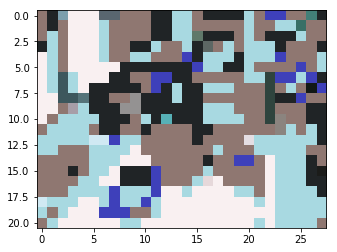

In [60]:
import csv
import numpy as np
from matplotlib import pyplot as plt

with open('segments.csv', 'r') as f:
    segments = [int(row[0]) for row in csv.reader(f)]

thumb = np.zeros(shape=(21,28,3))
groups = np.zeros(shape=(21,28,3))

for i in range(len(segments)):
    node1 = node_list[i]
    if node1[1] != "household_images/images/IMG_0317.jpg":
        continue
    node2 = node_list[segments[i]]
    # print(node[2])
    # print(node[3])
    thumb[node1[2]] = node1[3]
    groups[node1[2]] = node2[3]

plt.imshow(groups/255.0)
# plt.imshow(thumb/255.0)

plt.show()